In [ ]:
#!/usr/bin/env python3
"""
Balanced Intent Detection Pipeline with Class Imbalance Handling
Addresses class imbalance using multiple techniques for better performance
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
import random
import warnings
import pickle
warnings.filterwarnings('ignore')

# Download required NLTK data
def setup_nltk():
    """Download required NLTK data"""
    required_downloads = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']
    for item in required_downloads:
        try:
            nltk.data.find(f'tokenizers/{item}' if item == 'punkt' else 
                          f'corpora/{item}' if item in ['stopwords', 'wordnet'] else
                          f'taggers/{item}')
        except LookupError:
            print(f"Downloading NLTK {item}...")
            nltk.download(item, quiet=True)

class TextAugmentation:
    """Class for text data augmentation to handle imbalance"""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def synonym_replacement(self, sentence, n=1):
        """Replace n words with their synonyms"""
        words = sentence.split()
        new_words = words.copy()
        random_word_list = list(set([word for word in words if word not in self.stop_words]))
        random.shuffle(random_word_list)
        
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = []
            for syn in wordnet.synsets(random_word):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())
            
            if len(synonyms) >= 1:
                synonym = random.choice(synonyms)
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            
            if num_replaced >= n:
                break
                
        return ' '.join(new_words)
    
    def random_insertion(self, sentence, n=1):
        """Insert n random synonyms into the sentence"""
        words = sentence.split()
        for _ in range(n):
            random_word = random.choice([word for word in words if word not in self.stop_words])
            synonyms = []
            for syn in wordnet.synsets(random_word):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())
            
            if len(synonyms) >= 1:
                random_synonym = random.choice(synonyms)
                random_idx = random.randint(0, len(words))
                words.insert(random_idx, random_synonym)
        
        return ' '.join(words)
    
    def random_swap(self, sentence, n=1):
        """Swap positions of n pairs of words"""
        words = sentence.split()
        for _ in range(n):
            if len(words) >= 2:
                idx1, idx2 = random.sample(range(len(words)), 2)
                words[idx1], words[idx2] = words[idx2], words[idx1]
        
        return ' '.join(words)
    
    def random_deletion(self, sentence, p=0.1):
        """Delete words with probability p"""
        words = sentence.split()
        if len(words) == 1:
            return sentence
        
        new_words = []
        for word in words:
            if random.uniform(0, 1) > p:
                new_words.append(word)
        
        if len(new_words) == 0:
            return random.choice(words)
        
        return ' '.join(new_words)
    
    def paraphrase_sentence(self, sentence):
        """Generate paraphrases using multiple techniques"""
        paraphrases = []
        
        # Original sentence
        paraphrases.append(sentence)
        
        # Synonym replacement
        paraphrases.append(self.synonym_replacement(sentence, n=1))
        paraphrases.append(self.synonym_replacement(sentence, n=2))
        
        # Random insertion
        paraphrases.append(self.random_insertion(sentence, n=1))
        
        # Random swap
        paraphrases.append(self.random_swap(sentence, n=1))
        
        # Random deletion
        paraphrases.append(self.random_deletion(sentence, p=0.1))
        
        # Remove duplicates and empty strings
        paraphrases = list(set([p for p in paraphrases if p and len(p.strip()) > 0]))
        
        return paraphrases

class BalancedIntentDetectionPipeline:
    """Enhanced pipeline with class imbalance handling"""
    
    def __init__(self, balance_method='smote'):
        self.vectorizer = None
        self.model = None
        self.label_encoder = None
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        self.model_type = None
        self.balance_method = balance_method
        self.augmenter = TextAugmentation()
        self.class_weights = None
        
    def preprocess_text(self, text):
        """Preprocess text with enhanced cleaning"""
        if pd.isna(text):
            return ""
            
        text = str(text).lower()
        
        # Keep important punctuation for questions
        text = re.sub(r'[^\w\s\?]', ' ', text)
        
        # Tokenize and remove stopwords
        words = text.split()
        words = [word for word in words if word not in self.stop_words and len(word) > 1]
        
        # Stem words
        words = [self.stemmer.stem(word) for word in words]
        
        return ' '.join(words)
    
    def augment_minority_classes(self, df, target_samples=30):
        """Augment minority classes using text augmentation"""
        print("Augmenting minority classes...")
        
        augmented_data = []
        class_counts = df['label'].value_counts()
        
        for label in class_counts.index:
            current_count = class_counts[label]
            class_data = df[df['label'] == label].copy()
            
            # Add original samples
            augmented_data.extend(class_data.to_dict('records'))
            
            # If class needs augmentation
            if current_count < target_samples:
                needed_samples = target_samples - current_count
                print(f"  {label}: {current_count} -> {target_samples} samples")
                
                # Generate augmented samples
                original_sentences = class_data['sentence'].tolist()
                generated_count = 0
                
                while generated_count < needed_samples:
                    for sentence in original_sentences:
                        if generated_count >= needed_samples:
                            break
                            
                        # Generate paraphrases
                        paraphrases = self.augmenter.paraphrase_sentence(sentence)
                        
                        for paraphrase in paraphrases[1:]:  # Skip original
                            if generated_count >= needed_samples:
                                break
                                
                            augmented_data.append({
                                'sentence': paraphrase,
                                'label': label
                            })
                            generated_count += 1
        
        augmented_df = pd.DataFrame(augmented_data)
        print(f"Dataset augmented: {len(df)} -> {len(augmented_df)} samples")
        
        return augmented_df
    
    def prepare_data(self, df, use_augmentation=True):
        """Prepare data with optional augmentation"""
        print("Preparing data...")
        
        # Augment data if requested
        if use_augmentation:
            df = self.augment_minority_classes(df)
        
        # Preprocess text
        df['processed_sentence'] = df['sentence'].apply(self.preprocess_text)
        
        # Remove empty processed sentences
        df = df[df['processed_sentence'].str.len() > 0]
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        df['encoded_label'] = self.label_encoder.fit_transform(df['label'])
        
        # Calculate class weights
        classes = np.unique(df['encoded_label'])
        self.class_weights = compute_class_weight(
            'balanced', 
            classes=classes, 
            y=df['encoded_label']
        )
        
        print(f"Final dataset: {len(df)} samples, {len(self.label_encoder.classes_)} classes")
        return df
    
    def apply_smote(self, X_vectorized, y):
        """Apply SMOTE for oversampling"""
        print("Applying SMOTE for class balancing...")
        
        # Use SMOTETomek which combines SMOTE with Tomek links cleaning
        smote_tomek = SMOTETomek(
            smote=SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y))-1)),
            tomek=TomekLinks(),
            random_state=42
        )
        
        X_balanced, y_balanced = smote_tomek.fit_resample(X_vectorized, y)
        
        print(f"SMOTE applied: {X_vectorized.shape[0]} -> {X_balanced.shape[0]} samples")
        return X_balanced, y_balanced
    
    def train(self, X, y, model_type='logistic'):
        """Train the model with class balancing"""
        print(f"Training {model_type} model with {self.balance_method} balancing...")
        
        # Vectorize text
        self.vectorizer = TfidfVectorizer(
            max_features=2000,
            ngram_range=(1, 3),  # Include trigrams
            min_df=1,
            max_df=0.9,
            sublinear_tf=True
        )
        
        X_vectorized = self.vectorizer.fit_transform(X)
        print(f"Feature matrix shape: {X_vectorized.shape}")
        
        # Apply balancing method
        if self.balance_method == 'smote':
            X_vectorized, y = self.apply_smote(X_vectorized, y)
        
        # Create class weight dictionary
        class_weight_dict = {}
        if self.balance_method == 'class_weight':
            unique_classes = np.unique(y)
            for i, cls in enumerate(unique_classes):
                class_weight_dict[cls] = self.class_weights[i]
        else:
            class_weight_dict = 'balanced'
        
        # Choose and configure model
        if model_type == 'logistic':
            self.model = LogisticRegression(
                random_state=42, 
                max_iter=2000, 
                class_weight=class_weight_dict if self.balance_method == 'class_weight' else None,
                C=1.0
            )
        elif model_type == 'svm':
            self.model = SVC(
                kernel='linear', 
                random_state=42, 
                class_weight=class_weight_dict if self.balance_method == 'class_weight' else None,
                C=1.0
            )
        elif model_type == 'naive_bayes':
            self.model = MultinomialNB(alpha=0.1)
        elif model_type == 'random_forest':
            self.model = RandomForestClassifier(
                n_estimators=200, 
                random_state=42, 
                class_weight=class_weight_dict if self.balance_method == 'class_weight' else None,
                max_depth=10
            )
        
        # Train model
        self.model.fit(X_vectorized, y)
        self.model_type = model_type
        
        print(f"Model trained successfully!")
        return X_vectorized
    
    def predict(self, X):
        """Make predictions"""
        if isinstance(X, list):
            X = pd.Series(X)
        
        X_processed = X.apply(self.preprocess_text)
        X_vectorized = self.vectorizer.transform(X_processed)
        predictions = self.model.predict(X_vectorized)
        predicted_labels = self.label_encoder.inverse_transform(predictions)
        
        return predicted_labels
    
    def evaluate(self, X_test, y_test):
        """Evaluate with focus on balanced metrics"""
        X_test_processed = X_test.apply(self.preprocess_text)
        X_test_vectorized = self.vectorizer.transform(X_test_processed)
        predictions = self.model.predict(X_test_vectorized)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, predictions)
        macro_f1 = f1_score(y_test, predictions, average='macro')
        weighted_f1 = f1_score(y_test, predictions, average='weighted')
        
        report = classification_report(
            y_test, predictions, 
            target_names=self.label_encoder.classes_, 
            output_dict=True,
            zero_division=0
        )
        
        return accuracy, report, predictions, macro_f1, weighted_f1

def plot_class_distribution_comparison(original_df, balanced_df):
    """Plot original vs balanced class distribution"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original distribution
    original_counts = original_df['label'].value_counts()
    ax1.bar(range(len(original_counts)), original_counts.values)
    ax1.set_title('Original Class Distribution')
    ax1.set_xlabel('Intent Classes')
    ax1.set_ylabel('Number of Samples')
    ax1.set_xticks(range(len(original_counts)))
    ax1.set_xticklabels(original_counts.index, rotation=45, ha='right')
    
    # Balanced distribution
    balanced_counts = balanced_df['label'].value_counts()
    ax2.bar(range(len(balanced_counts)), balanced_counts.values)
    ax2.set_title('Balanced Class Distribution')
    ax2.set_xlabel('Intent Classes')
    ax2.set_ylabel('Number of Samples')
    ax2.set_xticks(range(len(balanced_counts)))
    ax2.set_xticklabels(balanced_counts.index, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

def compare_balance_methods(df):
    """Compare different class balancing methods"""
    print("\n" + "="*80)
    print("COMPARING CLASS BALANCING METHODS")
    print("="*80)
    
    # Split data first
    X = df['sentence']
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    train_df = pd.DataFrame({'sentence': X_train, 'label': y_train})
    test_df = pd.DataFrame({'sentence': X_test, 'label': y_test})
    
    methods = [
        ('no_balance', 'No Balancing'),
        ('augmentation', 'Text Augmentation'),
        ('class_weight', 'Class Weighting'),
        ('smote', 'SMOTE + Augmentation')
    ]
    
    results = {}
    
    for method_id, method_name in methods:
        print(f"\n{'-'*50}")
        print(f"Testing: {method_name}")
        print(f"{'-'*50}")
        
        # Configure pipeline
        if method_id == 'no_balance':
            pipeline = BalancedIntentDetectionPipeline(balance_method='none')
            df_processed = pipeline.prepare_data(train_df, use_augmentation=False)
        elif method_id == 'augmentation':
            pipeline = BalancedIntentDetectionPipeline(balance_method='none')
            df_processed = pipeline.prepare_data(train_df, use_augmentation=True)
        elif method_id == 'class_weight':
            pipeline = BalancedIntentDetectionPipeline(balance_method='class_weight')
            df_processed = pipeline.prepare_data(train_df, use_augmentation=False)
        else:  # smote
            pipeline = BalancedIntentDetectionPipeline(balance_method='smote')
            df_processed = pipeline.prepare_data(train_df, use_augmentation=True)
        
        # Train model
        X_processed = df_processed['processed_sentence']
        y_processed = df_processed['encoded_label']
        
        pipeline.train(X_processed, y_processed, 'logistic')
        
        # Evaluate
        test_df_processed = test_df.copy()
        test_df_processed['processed_sentence'] = test_df_processed['sentence'].apply(pipeline.preprocess_text)
        test_df_processed['encoded_label'] = pipeline.label_encoder.transform(test_df_processed['label'])
        
        accuracy, report, predictions, macro_f1, weighted_f1 = pipeline.evaluate(
            test_df_processed['processed_sentence'], 
            test_df_processed['encoded_label']
        )
        
        results[method_id] = {
            'method_name': method_name,
            'accuracy': accuracy,
            'macro_f1': macro_f1,
            'weighted_f1': weighted_f1,
            'report': report
        }
        
        print(f"Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Macro F1: {macro_f1:.4f}")
        print(f"  Weighted F1: {weighted_f1:.4f}")
    
    # Summary comparison
    print(f"\n" + "="*80)
    print("BALANCING METHODS COMPARISON SUMMARY")
    print("="*80)
    
    print(f"{'Method':<25} {'Accuracy':<10} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 65)
    
    for method_id, result in results.items():
        print(f"{result['method_name']:<25} {result['accuracy']:<10.4f} "
              f"{result['macro_f1']:<10.4f} {result['weighted_f1']:<12.4f}")
    
    # Find best method
    best_method = max(results.keys(), key=lambda k: results[k]['macro_f1'])
    print(f"\nBest method based on Macro F1: {results[best_method]['method_name']}")
    print(f"Macro F1 improvement: {results[best_method]['macro_f1']:.4f} vs {results['no_balance']['macro_f1']:.4f}")
    
    return results

def main():
    """Main function"""
    setup_nltk()
    
    # Load data
    try:
        df = pd.read_csv('sofmattress_train.csv')
    except FileNotFoundError:
        print("Error: sofmattress_train.csv not found!")
        return
    
    print("="*80)
    print("BALANCED INTENT DETECTION PIPELINE")
    print("="*80)
    
    # Analyze original class distribution
    print("\nOriginal Class Distribution:")
    class_counts = df['label'].value_counts()
    print(class_counts)
    
    print(f"\nClass Imbalance Ratio: {class_counts.max() / class_counts.min():.2f}:1")
    print(f"Standard Deviation: {class_counts.std():.2f}")
    
    # Compare all balancing methods
    results = compare_balance_methods(df)
    
    # Train final model with best method (SMOTE + Augmentation)
    print(f"\n" + "="*80)
    print("TRAINING FINAL MODEL WITH BEST BALANCING METHOD")
    print("="*80)
    
    pipeline = BalancedIntentDetectionPipeline(balance_method='smote')
    
    # Prepare data
    df_processed = pipeline.prepare_data(df, use_augmentation=True)
    
    # Show balanced distribution
    print("\nBalanced Class Distribution:")
    balanced_counts = df_processed['label'].value_counts()
    print(balanced_counts)
    
    # Split data
    X = df_processed['processed_sentence']
    y = df_processed['encoded_label']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train final model
    pipeline.train(X_train, y_train, 'logistic')
    
    # Final evaluation
    accuracy, report, predictions, macro_f1, weighted_f1 = pipeline.evaluate(X_test, y_test)
    
    print(f"\nFinal Model Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Macro F1: {macro_f1:.4f}")
    print(f"  Weighted F1: {weighted_f1:.4f}")
    
    # Detailed per-class results
    print(f"\nPer-Class Performance:")
    print("-" * 80)
    print(f"{'Intent':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 80)
    
    for intent, metrics in report.items():
        if intent not in ['accuracy', 'macro avg', 'weighted avg']:
            print(f"{intent:<25} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} "
                  f"{metrics['f1-score']:<10.3f} {int(metrics['support']):<10}")
    
    # Test predictions
    print(f"\n" + "="*80)
    print("SAMPLE PREDICTIONS")
    print("="*80)
    
    test_queries = [
        "I want EMI option",
        "What is warranty period?",
        "Cancel my order please",
        "Check if you deliver to my pincode",
        "What are ortho mattress features?",
        "Cost of the mattress?",
        "I want to return it",
        "What sizes available?",
        "Any offers running?",
        "Need custom size mattress"
    ]
    
    predictions = pipeline.predict(test_queries)
    
    for query, pred in zip(test_queries, predictions):
        print(f"'{query}' -> {pred}")
    
    # Save model
    pipeline.save_model('balanced_intent_model.pkl')
    print(f"\nBalanced model saved as: balanced_intent_model.pkl")
    
    return pipeline

def save_model(self, filepath):
    """Save the trained model"""
    model_data = {
        'vectorizer': self.vectorizer,
        'model': self.model,
        'label_encoder': self.label_encoder,
        'model_type': self.model_type,
        'balance_method': self.balance_method
    }
    with open(filepath, 'wb') as f:
        pickle.dump(model_data, f)
    print(f"Model saved to {filepath}")

# Add save method to the class
BalancedIntentDetectionPipeline.save_model = save_model

if __name__ == "__main__":
    print("Starting Balanced Intent Detection Pipeline...")
    try:
        best_pipeline = main()
        print("\nPipeline completed successfully!")
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
def main():
    """Main function to run the complete pipeline"""
    
    # Setup
    setup_nltk()
    
    # Load data
    try:
        df = pd.read_csv('sofmattress_train.csv')
    except FileNotFoundError:
        print("Error: sofmattress_train.csv not found!")
        print("Please ensure the CSV file is in the same directory as this script.")
        return
    
    # Analyze dataset
    analyze_dataset(df)
    
    # Initialize pipeline
    pipeline = IntentDetectionPipeline()
    
    # Prepare data
    df_processed = pipeline.prepare_data(df)
    
    # Split data
    X = df_processed['processed_sentence']
    y = df_processed['encoded_label']
    
    # Stratified split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nData split:")
    print(f"  Train set size: {len(X_train)}")
    print(f"  Test set size: {len(X_test)}")
    
    # Train and evaluate different models
    models = ['logistic', 'svm', 'naive_bayes', 'random_forest']
    results = {}
    
    print("\n" + "="*60)
    print("MODEL TRAINING AND EVALUATION")
    print("="*60)
    
    for model_type in models:
        print(f"\n{'-'*40}")
        print(f"Training {model_type.upper()} model...")
        print(f"{'-'*40}")
        
        # Create new pipeline for each model
        model_pipeline = IntentDetectionPipeline()
        model_pipeline.label_encoder = pipeline.label_encoder
        
        # Train model
        model_pipeline.train(X_train, y_train, model_type)
        
        # Evaluate
        accuracy, report, predictions = model_pipeline.evaluate(X_test, y_test)
        
        results[model_type] = {
            'accuracy': accuracy,
            'report': report,
            'predictions': predictions,
            'pipeline': model_pipeline
        }
        
        print(f"Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Macro F1-Score: {report['macro avg']['f1-score']:.4f}")
        print(f"  Weighted F1-Score: {report['weighted avg']['f1-score']:.4f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best_pipeline = results[best_model_name]['pipeline']
    
    print(f"\n" + "="*60)
    print(f"BEST MODEL: {best_model_name.upper()}")
    print("="*60)
    print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f}")
    
    # Detailed evaluation of best model
    accuracy, report, predictions = best_pipeline.evaluate(X_test, y_test)
    
    print(f"\nDetailed Classification Report:")
    print("-" * 80)
    print(f"{'Intent':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 80)
    
    for intent, metrics in report.items():
        if intent not in ['accuracy', 'macro avg', 'weighted avg']:
            print(f"{intent:<25} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} "
                  f"{metrics['f1-score']:<10.3f} {int(metrics['support']):<10}")
    
    print("-" * 80)
    print(f"{'Macro Avg':<25} {report['macro avg']['precision']:<10.3f} "
          f"{report['macro avg']['recall']:<10.3f} {report['macro avg']['f1-score']:<10.3f}")
    print(f"{'Weighted Avg':<25} {report['weighted avg']['precision']:<10.3f} "
          f"{report['weighted avg']['recall']:<10.3f} {report['weighted avg']['f1-score']:<10.3f}")
    
    # Cross-validation
    print(f"\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    
    cv_scores = cross_val_score(
        best_pipeline.model, 
        best_pipeline.vectorizer.transform(X), 
        y, 
        cv=5, 
        scoring='accuracy'
    )
    
    print(f"5-Fold Cross-Validation Accuracy:")
    print(f"  Mean: {cv_scores.mean():.4f}")
    print(f"  Std: {cv_scores.std():.4f}")
    print(f"  95% Confidence Interval: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Individual scores: {[f'{score:.4f}' for score in cv_scores]}")
    
    # Test with sample predictions
    print(f"\n" + "="*60)
    print("SAMPLE PREDICTIONS")
    print("="*60)
    
    test_sentences = [
        "I want to pay in installments",
        "What is the warranty period?", 
        "Can you deliver to my pincode?",
        "What are the features of ortho mattress?",
        "I want to cancel my order",
        "Do you accept cash on delivery?",
        "What's the difference between ergo and ortho?",
        "I need to return my mattress",
        "What sizes are available?",
        "How much does it cost?"
    ]
    
    predictions = best_pipeline.predict(test_sentences)
    probabilities = best_pipeline.predict_proba(test_sentences)
    
    print("Test Query -> Predicted Intent")
    print("-" * 60)
    for i, (sentence, prediction) in enumerate(zip(test_sentences, predictions)):
        if probabilities is not None:
            max_prob = probabilities[i].max()
            print(f"'{sentence}' -> {prediction} (confidence: {max_prob:.3f})")
        else:
            print(f"'{sentence}' -> {prediction}")
    
    # Save the best model
    model_filename = f'best_intent_model_{best_model_name}.pkl'
    best_pipeline.save_model(model_filename)
    
    print(f"\n" + "="*60)
    print("MODEL COMPARISON SUMMARY")
    print("="*60)
    
    print(f"{'Model':<15} {'Accuracy':<10} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 50)
    for model_name, result in results.items():
        print(f"{model_name:<15} {result['accuracy']:<10.4f} "
              f"{result['report']['macro avg']['f1-score']:<10.4f} "
              f"{result['report']['weighted avg']['f1-score']:<12.4f}")
    
    print(f"\nBest model saved as: {model_filename}")
    print("="*60)
    
    return best_pipeline, results

# Example usage for loading and using saved model
def use_saved_model(model_path, test_queries):
    """Example of how to use a saved model"""
    pipeline = IntentDetectionPipeline()
    pipeline.load_model(model_path)
    
    predictions = pipeline.predict(test_queries)
    
    print("Predictions from saved model:")
    for query, prediction in zip(test_queries, predictions):
        print(f"'{query}' -> {prediction}")

if __name__ == "__main__":
    # Run the complete pipeline
    print("Starting Intent Detection Pipeline...")
    print("="*60)
    
    try:
        best_model, all_results = main()
        print("\nPipeline completed successfully!")
        
        # Example of using the saved model
        print("\n" + "="*60)
        print("EXAMPLE: Using Saved Model")
        print("="*60)
        
        example_queries = [
            "Can I get EMI?",
            "What's the warranty?",
            "I want to cancel"
        ]
        
        predictions = best_model.predict(example_queries)
        for query, pred in zip(example_queries, predictions):
            print(f"'{query}' -> {pred}")
            
    except Exception as e:
        print(f"Error: {e}")
        print("Please ensure 'sofmattress_train.csv' is in the same directory.")

In [ ]:
class TextAugmentation:
    """Class for text data augmentation to handle imbalance"""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def synonym_replacement(self, sentence, n=1):
        """Replace n words with their synonyms"""
        words = sentence.split()
        new_words = words.copy()
        random_word_list = list(set([word for word in words if word not in self.stop_words]))
        random.shuffle(random_word_list)
        
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = []
            for syn in wordnet.synsets(random_word):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())
            
            if len(synonyms) >= 1:
                synonym = random.choice(synonyms)
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            
            if num_replaced >= n:
                break
                
        return ' '.join(new_words)
    
    def random_insertion(self, sentence, n=1):
        """Insert n random synonyms into the sentence"""
        words = sentence.split()
        for _ in range(n):
            random_word = random.choice([word for word in words if word not in self.stop_words])
            synonyms = []
            for syn in wordnet.synsets(random_word):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())
            
            if len(synonyms) >= 1:
                random_synonym = random.choice(synonyms)
                random_idx = random.randint(0, len(words))
                words.insert(random_idx, random_synonym)
        
        return ' '.join(words)
    
    def random_swap(self, sentence, n=1):
        """Swap positions of n pairs of words"""
        words = sentence.split()
        for _ in range(n):
            if len(words) >= 2:
                idx1, idx2 = random.sample(range(len(words)), 2)
                words[idx1], words[idx2] = words[idx2], words[idx1]
        
        return ' '.join(words)
    
    def random_deletion(self, sentence, p=0.1):
        """Delete words with probability p"""
        words = sentence.split()
        if len(words) == 1:
            return sentence
        
        new_words = []
        for word in words:
            if random.uniform(0, 1) > p:
                new_words.append(word)
        
        if len(new_words) == 0:
            return random.choice(words)
        
        return ' '.join(new_words)
    
    def paraphrase_sentence(self, sentence):
        """Generate paraphrases using multiple techniques"""
        paraphrases = []
        
        # Original sentence
        paraphrases.append(sentence)
        
        # Synonym replacement
        paraphrases.append(self.synonym_replacement(sentence, n=1))
        paraphrases.append(self.synonym_replacement(sentence, n=2))
        
        # Random insertion
        paraphrases.append(self.random_insertion(sentence, n=1))
        
        # Random swap
        paraphrases.append(self.random_swap(sentence, n=1))
        
        # Random deletion
        paraphrases.append(self.random_deletion(sentence, p=0.1))
        
        # Remove duplicates and empty strings
        paraphrases = list(set([p for p in paraphrases if p and len(p.strip()) > 0]))
        
        return paraphrases


Starting Enhanced Intent Detection with Model Comparison...
ENHANCED INTENT DETECTION WITH MODEL COMPARISON

Original Class Distribution:
  DISTRIBUTORS: 34 samples
  EMI: 25 samples
  MATTRESS_COST: 22 samples
  LEAD_GEN: 21 samples
  PRODUCT_VARIANTS: 21 samples
  ORDER_STATUS: 21 samples
  WHAT_SIZE_TO_ORDER: 20 samples
  100_NIGHT_TRIAL_OFFER: 18 samples
  ORTHO_FEATURES: 17 samples
  RETURN_EXCHANGE: 14 samples
  COD: 12 samples
  COMPARISON: 11 samples
  ERGO_FEATURES: 11 samples
  ABOUT_SOF_MATTRESS: 11 samples
  DELAY_IN_DELIVERY: 11 samples
  CANCEL_ORDER: 10 samples
  PILLOWS: 10 samples
  CHECK_PINCODE: 10 samples
  WARRANTY: 10 samples
  OFFERS: 10 samples
  SIZE_CUSTOMIZATION: 9 samples

Class Imbalance Ratio: 3.78:1
Preparing data...
Augmenting minority classes...
  EMI: 25 -> 30 samples
  MATTRESS_COST: 22 -> 30 samples
  LEAD_GEN: 21 -> 30 samples
  PRODUCT_VARIANTS: 21 -> 30 samples
  ORDER_STATUS: 21 -> 30 samples
  WHAT_SIZE_TO_ORDER: 20 -> 30 samples
  100_NIGHT_TRI

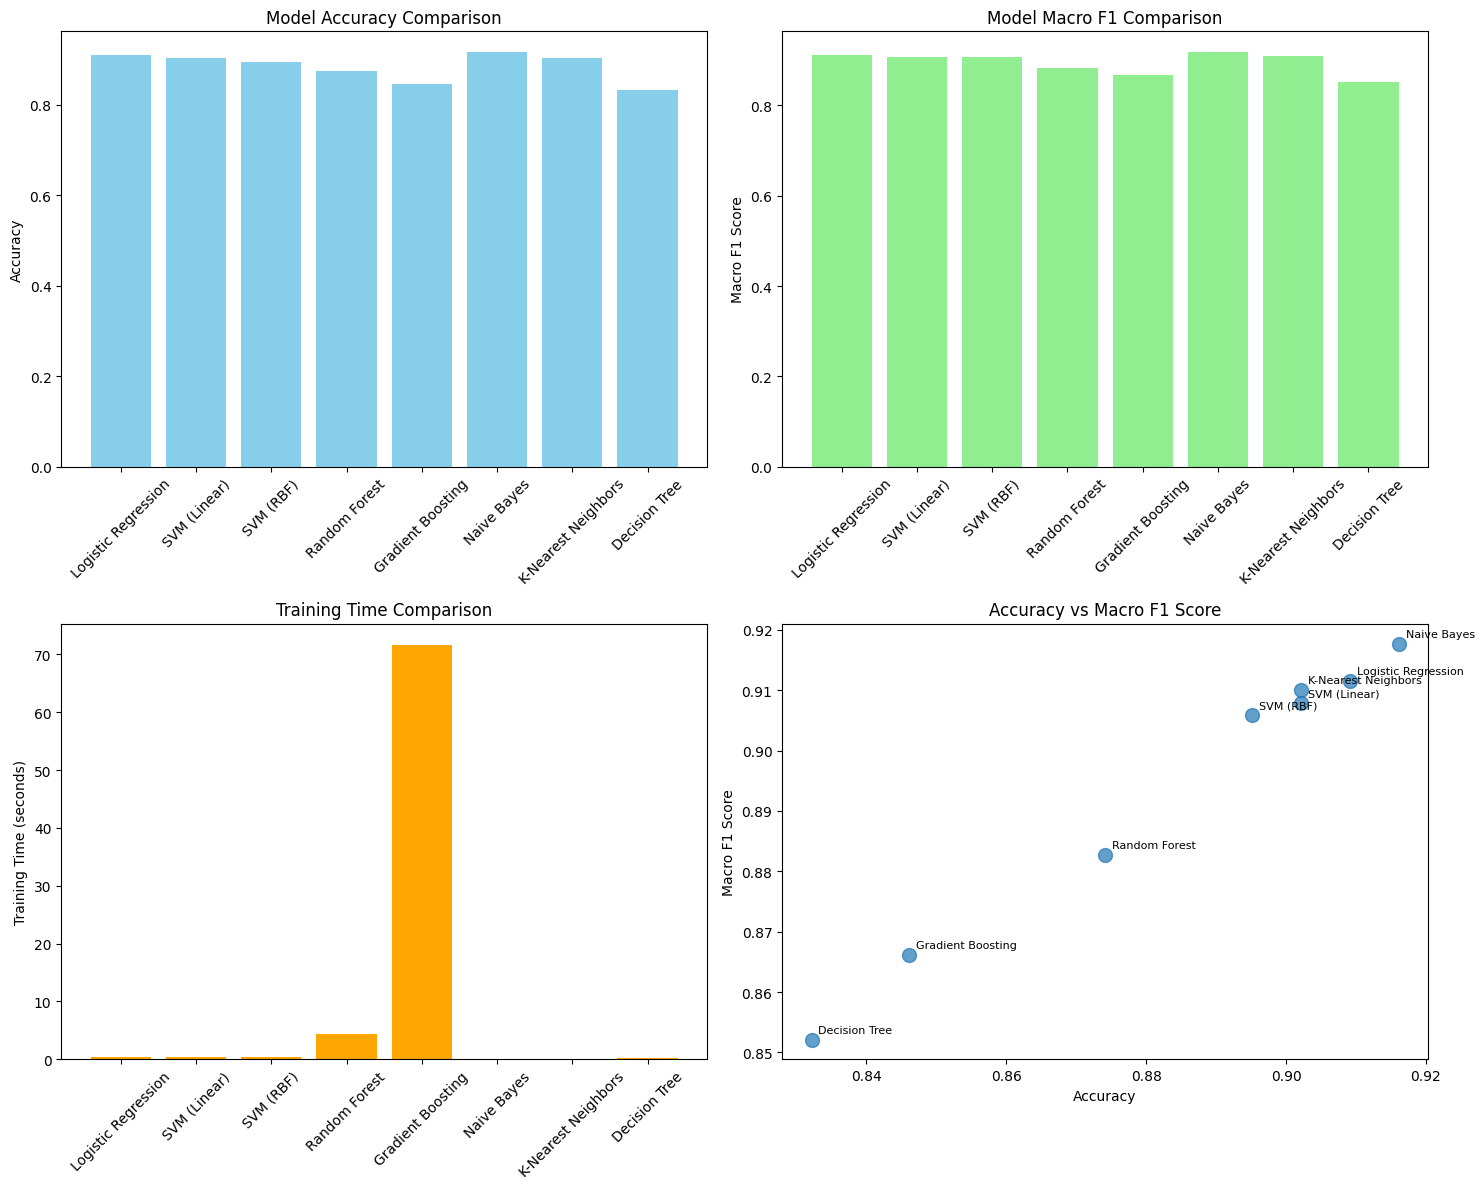


🔮 TESTING PREDICTIONS WITH BEST MODEL: Naive Bayes
'I want EMI option please' → EMI (confidence: 0.869)
'What is warranty period?' → WARRANTY (confidence: 0.957)
'Cancel my order' → CANCEL_ORDER (confidence: 0.987)
'Check pincode delivery' → CHECK_PINCODE (confidence: 0.947)
'Ortho mattress features' → ORTHO_FEATURES (confidence: 0.672)
'How much does it cost?' → MATTRESS_COST (confidence: 0.878)
'Return policy details' → RETURN_EXCHANGE (confidence: 0.459)
'Available sizes' → WHAT_SIZE_TO_ORDER (confidence: 0.398)
'Any current offers?' → ORDER_STATUS (confidence: 0.226)
'Custom size mattress' → SIZE_CUSTOMIZATION (confidence: 0.981)

💾 Best model saved: Naive Bayes

Model comparison completed successfully! 🎉


In [16]:
#!/usr/bin/env python3
"""
Enhanced Intent Detection Pipeline with Model Comparison and Class Imbalance Handling
Compares multiple ML models with comprehensive evaluation metrics
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score, roc_auc_score,
                           precision_recall_curve, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
import random
import warnings
import pickle
import time
from collections import defaultdict
warnings.filterwarnings('ignore')

# Download required NLTK data
def setup_nltk():
    """Download required NLTK data"""
    required_downloads = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']
    for item in required_downloads:
        try:
            nltk.data.find(f'tokenizers/{item}' if item == 'punkt' else 
                          f'corpora/{item}' if item in ['stopwords', 'wordnet'] else
                          f'taggers/{item}')
        except LookupError:
            print(f"Downloading NLTK {item}...")
            nltk.download(item, quiet=True)

class TextAugmentation:
    """Class for text data augmentation to handle imbalance"""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def synonym_replacement(self, sentence, n=1):
        """Replace n words with their synonyms"""
        words = sentence.split()
        new_words = words.copy()
        random_word_list = list(set([word for word in words if word not in self.stop_words]))
        random.shuffle(random_word_list)
        
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = []
            for syn in wordnet.synsets(random_word):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())
            
            if len(synonyms) >= 1:
                synonym = random.choice(synonyms)
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            
            if num_replaced >= n:
                break
                
        return ' '.join(new_words)
    
    def paraphrase_sentence(self, sentence):
        """Generate paraphrases using multiple techniques"""
        paraphrases = []
        paraphrases.append(sentence)
        paraphrases.append(self.synonym_replacement(sentence, n=1))
        paraphrases.append(self.synonym_replacement(sentence, n=2))
        
        # Remove duplicates and empty strings
        paraphrases = list(set([p for p in paraphrases if p and len(p.strip()) > 0]))
        return paraphrases

class ModelComparison:
    """Class for comprehensive model comparison"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
        self.vectorizer = None
        self.label_encoder = None
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        self.augmenter = TextAugmentation()
        # Initialize train/test split storage
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
    
    def preprocess_text(self, text):
        """Preprocess text with enhanced cleaning"""
        if pd.isna(text):
            return ""
            
        text = str(text).lower()
        text = re.sub(r'[^\w\s\?]', ' ', text)
        
        words = text.split()
        words = [word for word in words if word not in self.stop_words and len(word) > 1]
        words = [self.stemmer.stem(word) for word in words]
        
        return ' '.join(words)
    
    def augment_minority_classes(self, df, target_samples=30):
        """Augment minority classes using text augmentation"""
        print("Augmenting minority classes...")
        
        augmented_data = []
        class_counts = df['label'].value_counts()
        
        for label in class_counts.index:
            current_count = class_counts[label]
            class_data = df[df['label'] == label].copy()
            
            # Add original samples
            augmented_data.extend(class_data.to_dict('records'))
            
            # If class needs augmentation
            if current_count < target_samples:
                needed_samples = target_samples - current_count
                print(f"  {label}: {current_count} -> {target_samples} samples")
                
                original_sentences = class_data['sentence'].tolist()
                generated_count = 0
                
                while generated_count < needed_samples:
                    for sentence in original_sentences:
                        if generated_count >= needed_samples:
                            break
                            
                        paraphrases = self.augmenter.paraphrase_sentence(sentence)
                        
                        for paraphrase in paraphrases[1:]:
                            if generated_count >= needed_samples:
                                break
                                
                            augmented_data.append({
                                'sentence': paraphrase,
                                'label': label
                            })
                            generated_count += 1
        
        augmented_df = pd.DataFrame(augmented_data)
        print(f"Dataset augmented: {len(df)} -> {len(augmented_df)} samples")
        return augmented_df
    
    def prepare_data(self, df, use_augmentation=True, use_smote=True):
        """Prepare data with balancing techniques"""
        print("Preparing data...")
        
        # Augment data if requested
        if use_augmentation:
            df = self.augment_minority_classes(df)
        
        # Preprocess text
        df['processed_sentence'] = df['sentence'].apply(self.preprocess_text)
        df = df[df['processed_sentence'].str.len() > 0]
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        df['encoded_label'] = self.label_encoder.fit_transform(df['label'])
        
        # Vectorize text
        self.vectorizer = TfidfVectorizer(
            max_features=2000,
            ngram_range=(1, 3),
            min_df=1,
            max_df=0.9,
            sublinear_tf=True
        )
        
        X_vectorized = self.vectorizer.fit_transform(df['processed_sentence'])
        y = df['encoded_label']
        
        # Apply SMOTE if requested
        if use_smote:
            print("Applying SMOTE for additional balancing...")
            smote_tomek = SMOTETomek(
                smote=SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y))-1)),
                tomek=TomekLinks(),
                random_state=42
            )
            X_vectorized, y = smote_tomek.fit_resample(X_vectorized, y)
            print(f"SMOTE applied: dataset balanced to {X_vectorized.shape[0]} samples")
        
        return X_vectorized, y
    
    def initialize_models(self):
        """Initialize all models for comparison"""
        self.models = {
            'logistic_regression': {
                'model': LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'),
                'name': 'Logistic Regression',
                'params': {
                    'C': [0.1, 1.0, 10.0],
                    'solver': ['liblinear', 'lbfgs']
                }
            },
            'svm_linear': {
                'model': SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True),
                'name': 'SVM (Linear)',
                'params': {
                    'C': [0.1, 1.0, 10.0],
                    'gamma': ['scale', 'auto']
                }
            },
            'svm_rbf': {
                'model': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True),
                'name': 'SVM (RBF)',
                'params': {
                    'C': [0.1, 1.0, 10.0],
                    'gamma': ['scale', 'auto']
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
                'name': 'Random Forest',
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [10, 20, None],
                    'min_samples_split': [2, 5]
                }
            },
            'gradient_boosting': {
                'model': GradientBoostingClassifier(random_state=42),
                'name': 'Gradient Boosting',
                'params': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.1, 0.2],
                    'max_depth': [3, 5]
                }
            },
            'naive_bayes': {
                'model': MultinomialNB(),
                'name': 'Naive Bayes',
                'params': {
                    'alpha': [0.1, 1.0, 10.0]
                }
            },
            'knn': {
                'model': KNeighborsClassifier(),
                'name': 'K-Nearest Neighbors',
                'params': {
                    'n_neighbors': [3, 5, 7],
                    'weights': ['uniform', 'distance']
                }
            },
            'decision_tree': {
                'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                'name': 'Decision Tree',
                'params': {
                    'max_depth': [10, 20, None],
                    'min_samples_split': [2, 5, 10]
                }
            }
        }
    
    def train_and_evaluate_model(self, model_key, X_train, X_test, y_train, y_test, use_grid_search=True):
        """Train and evaluate a single model"""
        model_info = self.models[model_key]
        model_name = model_info['name']
        
        print(f"\nTraining {model_name}...")
        start_time = time.time()
        
        if use_grid_search and len(model_info['params']) > 0:
            # Use GridSearchCV for hyperparameter tuning
            grid_search = GridSearchCV(
                model_info['model'],
                model_info['params'],
                cv=3,
                scoring='f1_macro',
                n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            # Train with default parameters
            best_model = model_info['model']
            best_model.fit(X_train, y_train)
            best_params = "Default"
        
        training_time = time.time() - start_time
        
        # Make predictions
        start_time = time.time()
        y_pred = best_model.predict(X_test)
        y_pred_proba = None
        
        if hasattr(best_model, 'predict_proba'):
            y_pred_proba = best_model.predict_proba(X_test)
        
        prediction_time = time.time() - start_time
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        macro_precision = precision_score(y_test, y_pred, average='macro')
        macro_recall = recall_score(y_test, y_pred, average='macro')
        
        # Calculate AUC if probabilities available
        macro_auc = None
        if y_pred_proba is not None:
            try:
                # Binarize labels for multiclass AUC
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                if y_test_bin.shape[1] > 1:
                    macro_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
            except:
                pass
        
        # Detailed classification report
        report = classification_report(
            y_test, y_pred,
            target_names=self.label_encoder.classes_,
            output_dict=True,
            zero_division=0
        )
        
        # Per-class metrics
        per_class_metrics = {}
        for class_name in self.label_encoder.classes_:
            if class_name in report:
                per_class_metrics[class_name] = {
                    'precision': report[class_name]['precision'],
                    'recall': report[class_name]['recall'],
                    'f1_score': report[class_name]['f1-score'],
                    'support': report[class_name]['support']
                }
        
        # Store results
        results = {
            'model_name': model_name,
            'best_model': best_model,
            'best_params': best_params,
            'accuracy': accuracy,
            'macro_f1': macro_f1,
            'weighted_f1': weighted_f1,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_auc': macro_auc,
            'training_time': training_time,
            'prediction_time': prediction_time,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'classification_report': report,
            'per_class_metrics': per_class_metrics,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        print(f"  Training completed in {training_time:.2f}s")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Macro F1: {macro_f1:.4f}")
        print(f"  Weighted F1: {weighted_f1:.4f}")
        if macro_auc:
            print(f"  Macro AUC: {macro_auc:.4f}")
        
        return results
    
    def compare_all_models(self, X, y, test_size=0.2):
        """Compare all models with comprehensive evaluation"""
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL COMPARISON")
        print("="*80)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        # Store splits for ensemble use
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Initialize models
        self.initialize_models()
        
        # Train and evaluate each model
        for model_key in self.models.keys():
            try:
                results = self.train_and_evaluate_model(
                    model_key, X_train, X_test, y_train, y_test
                )
                self.results[model_key] = results
            except Exception as e:
                print(f"Error training {self.models[model_key]['name']}: {e}")
        
        return X_test, y_test
    
    def create_ensemble_model(self):
        """Create and evaluate ensemble model"""
        print(f"\nCreating Ensemble Model...")
        
        # Check if we have stored splits
        if not hasattr(self, 'X_train') or not hasattr(self, 'X_test') or self.X_train is None:
            print("Error: Train/test splits not available. Run compare_all_models first.")
            return None
        
        # Check if we have enough successful models
        if len(self.results) < 2:
            print("Error: Need at least 2 trained models for ensemble.")
            return None
        
        X_train, X_test, y_train, y_test = self.X_train, self.X_test, self.y_train, self.y_test
        
        # Select top models based on macro F1 (up to 3)
        available_models = [(k, v) for k, v in self.results.items() if 'best_model' in v]
        if len(available_models) == 0:
            print("Error: No trained models available for ensemble.")
            return None
        
        top_models = sorted(
            available_models,
            key=lambda x: x[1]['macro_f1'],
            reverse=True
        )[:min(3, len(available_models))]
        
        estimators = []
        for model_key, results in top_models:
            try:
                estimators.append((model_key, results['best_model']))
            except Exception as e:
                print(f"Warning: Could not add {results['model_name']} to ensemble: {e}")
        
        if len(estimators) < 2:
            print("Error: Need at least 2 valid models for ensemble.")
            return None
        
        # Create voting classifier
        try:
            ensemble = VotingClassifier(estimators=estimators, voting='soft')
            
            start_time = time.time()
            ensemble.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Evaluate ensemble
            start_time = time.time()
            y_pred = ensemble.predict(X_test)
            prediction_time = time.time() - start_time
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            weighted_f1 = f1_score(y_test, y_pred, average='weighted')
            
            ensemble_results = {
                'model_name': 'Ensemble (Top Models)',
                'accuracy': accuracy,
                'macro_f1': macro_f1,
                'weighted_f1': weighted_f1,
                'training_time': training_time,
                'prediction_time': prediction_time,
                'component_models': [results['model_name'] for _, results in top_models]
            }
            
            self.results['ensemble'] = ensemble_results
            
            print(f"  Ensemble created with: {', '.join(ensemble_results['component_models'])}")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  Macro F1: {macro_f1:.4f}")
            
            return ensemble
            
        except Exception as e:
            print(f"Error creating ensemble: {e}")
            return None
    
    def print_detailed_comparison(self):
        """Print detailed comparison of all models"""
        print("\n" + "="*100)
        print("DETAILED MODEL COMPARISON RESULTS")
        print("="*100)
        
        # Overall comparison table
        print(f"\n{'Model':<20} {'Accuracy':<10} {'Macro F1':<10} {'Weighted F1':<12} {'Macro AUC':<10} {'Train Time':<12}")
        print("-" * 85)
        
        sorted_results = sorted(
            self.results.items(),
            key=lambda x: x[1]['macro_f1'],
            reverse=True
        )
        
        for model_key, results in sorted_results:
            auc_str = f"{results['macro_auc']:.4f}" if results.get('macro_auc') else "N/A"
            print(f"{results['model_name']:<20} {results['accuracy']:<10.4f} "
                  f"{results['macro_f1']:<10.4f} {results['weighted_f1']:<12.4f} "
                  f"{auc_str:<10} {results['training_time']:<12.2f}s")
        
        # Best model analysis
        best_model_key = sorted_results[0][0]
        best_results = sorted_results[0][1]
        
        print(f"\n🏆 BEST MODEL: {best_results['model_name']}")
        print(f"   Macro F1 Score: {best_results['macro_f1']:.4f}")
        print(f"   Accuracy: {best_results['accuracy']:.4f}")
        print(f"   Training Time: {best_results['training_time']:.2f}s")
        
        if 'best_params' in best_results and best_results['best_params'] != "Default":
            print(f"   Best Parameters: {best_results['best_params']}")
        
        # Per-class performance for best model
        if 'per_class_metrics' in best_results:
            print(f"\nPer-Class Performance (Best Model):")
            print(f"{'Intent':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
            print("-" * 70)
            
            for class_name, metrics in best_results['per_class_metrics'].items():
                print(f"{class_name:<25} {metrics['precision']:<10.3f} "
                      f"{metrics['recall']:<10.3f} {metrics['f1_score']:<10.3f} "
                      f"{int(metrics['support']):<10}")
        
        # Model insights
        print(f"\n📊 MODEL INSIGHTS:")
        
        # Best performing models by category
        best_accuracy = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        best_macro_f1 = max(self.results.items(), key=lambda x: x[1]['macro_f1'])
        fastest_training = min(self.results.items(), key=lambda x: x[1]['training_time'])
        
        print(f"   Best Accuracy: {best_accuracy[1]['model_name']} ({best_accuracy[1]['accuracy']:.4f})")
        print(f"   Best Macro F1: {best_macro_f1[1]['model_name']} ({best_macro_f1[1]['macro_f1']:.4f})")
        print(f"   Fastest Training: {fastest_training[1]['model_name']} ({fastest_training[1]['training_time']:.2f}s)")
        
        # Performance gaps
        worst_model = min(self.results.items(), key=lambda x: x[1]['macro_f1'])
        performance_gap = best_macro_f1[1]['macro_f1'] - worst_model[1]['macro_f1']
        print(f"   Performance Gap: {performance_gap:.4f} (Best vs Worst Macro F1)")
    
    def plot_model_comparison(self):
        """Create visualization comparing models"""
        if not self.results:
            return
        
        # Extract data for plotting
        models = []
        accuracies = []
        macro_f1s = []
        training_times = []
        
        for model_key, results in self.results.items():
            if model_key != 'ensemble':  # Plot ensemble separately
                models.append(results['model_name'])
                accuracies.append(results['accuracy'])
                macro_f1s.append(results['macro_f1'])
                training_times.append(results['training_time'])
        
        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Accuracy comparison
        ax1.bar(models, accuracies, color='skyblue')
        ax1.set_title('Model Accuracy Comparison')
        ax1.set_ylabel('Accuracy')
        ax1.tick_params(axis='x', rotation=45)
        
        # Macro F1 comparison
        ax2.bar(models, macro_f1s, color='lightgreen')
        ax2.set_title('Model Macro F1 Comparison')
        ax2.set_ylabel('Macro F1 Score')
        ax2.tick_params(axis='x', rotation=45)
        
        # Training time comparison
        ax3.bar(models, training_times, color='orange')
        ax3.set_title('Training Time Comparison')
        ax3.set_ylabel('Training Time (seconds)')
        ax3.tick_params(axis='x', rotation=45)
        
        # Accuracy vs F1 scatter plot
        ax4.scatter(accuracies, macro_f1s, s=100, alpha=0.7)
        for i, model in enumerate(models):
            ax4.annotate(model, (accuracies[i], macro_f1s[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        ax4.set_xlabel('Accuracy')
        ax4.set_ylabel('Macro F1 Score')
        ax4.set_title('Accuracy vs Macro F1 Score')
        
        plt.tight_layout()
        plt.show()
    
    def test_predictions(self, test_queries):
        """Test predictions with best model"""
        if not self.results:
            print("No trained models available!")
            return
        
        # Get best model (excluding ensemble if it failed)
        available_models = {k: v for k, v in self.results.items() if 'best_model' in v}
        if not available_models:
            print("No valid trained models available!")
            return
        
        best_model_key = max(available_models.keys(), key=lambda k: available_models[k]['macro_f1'])
        best_model = available_models[best_model_key]['best_model']
        
        print(f"\n🔮 TESTING PREDICTIONS WITH BEST MODEL: {available_models[best_model_key]['model_name']}")
        print("="*80)
        
        try:
            # Preprocess queries
            processed_queries = [self.preprocess_text(query) for query in test_queries]
            
            # Vectorize
            X_queries = self.vectorizer.transform(processed_queries)
            
            # Predict
            predictions = best_model.predict(X_queries)
            predicted_labels = self.label_encoder.inverse_transform(predictions)
            
            # Get probabilities if available
            if hasattr(best_model, 'predict_proba'):
                probabilities = best_model.predict_proba(X_queries)
                
                for i, (query, prediction) in enumerate(zip(test_queries, predicted_labels)):
                    confidence = probabilities[i].max()
                    print(f"'{query}' → {prediction} (confidence: {confidence:.3f})")
            else:
                for query, prediction in zip(test_queries, predicted_labels):
                    print(f"'{query}' → {prediction}")
                    
        except Exception as e:
            print(f"Error making predictions: {e}")
            print("This might be due to unseen vocabulary in test queries.")

def main():
    """Main function"""
    setup_nltk()
    
    # Load data
    try:
        df = pd.read_csv('sofmattress_train.csv')
    except FileNotFoundError:
        print("Error: sofmattress_train.csv not found!")
        return
    
    print("="*80)
    print("ENHANCED INTENT DETECTION WITH MODEL COMPARISON")
    print("="*80)
    
    # Show original class distribution
    print("\nOriginal Class Distribution:")
    class_counts = df['label'].value_counts()
    for label, count in class_counts.items():
        print(f"  {label}: {count} samples")
    
    print(f"\nClass Imbalance Ratio: {class_counts.max() / class_counts.min():.2f}:1")
    
    # Initialize comparison class
    comparator = ModelComparison()
    
    # Prepare balanced data
    X, y = comparator.prepare_data(df, use_augmentation=True, use_smote=True)
    
    print(f"\nFinal balanced dataset: {X.shape[0]} samples, {X.shape[1]} features")
    
    # Compare all models
    X_test, y_test = comparator.compare_all_models(X, y)
    
    # Create ensemble model
    ensemble = comparator.create_ensemble_model()
    
    # Print detailed comparison
    comparator.print_detailed_comparison()
    
    # Plot comparison
    try:
        comparator.plot_model_comparison()
    except Exception as e:
        print(f"Could not create plots: {e}")
    
    # Test with sample queries
    test_queries = [
        "I want EMI option please",
        "What is warranty period?",
        "Cancel my order",
        "Check pincode delivery",
        "Ortho mattress features",
        "How much does it cost?",
        "Return policy details",
        "Available sizes",
        "Any current offers?",
        "Custom size mattress"
    ]
    
    comparator.test_predictions(test_queries)
    
    # Save best model
    best_model_key = max(comparator.results.keys(), 
                        key=lambda k: comparator.results[k]['macro_f1'])
    
    if best_model_key != 'ensemble':
        best_model_data = {
            'model': comparator.results[best_model_key]['best_model'],
            'vectorizer': comparator.vectorizer,
            'label_encoder': comparator.label_encoder,
            'model_name': comparator.results[best_model_key]['model_name']
        }
        
        with open('best_intent_model_comparison.pkl', 'wb') as f:
            pickle.dump(best_model_data, f)
        
        print(f"\n💾 Best model saved: {comparator.results[best_model_key]['model_name']}")
    
    return comparator

if __name__ == "__main__":
    print("Starting Enhanced Intent Detection with Model Comparison...")
    try:
        comparator = main()
        print("\nModel comparison completed successfully! 🎉")
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

In [14]:
import joblib

# Load the .pkl file
data = joblib.load("balanced_intent_model.pkl")

# Extract components
vectorizer = data['vectorizer']
model = data['model']
label_encoder = data['label_encoder']  # Optional: if labels are encoded

# Sample input text
sentences = [
   "Can I get a call from your team?"
]

# Convert text to features
X = vectorizer.transform(sentences)

# Predict using the model
predicted_labels_encoded = model.predict(X)

# Decode labels if label_encoder was used
predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Show results
for sentence, label in zip(sentences, predicted_labels):
    print(f"Sentence: {sentence}\nPredicted Label: {label}\n")


Sentence: Can I get a call from your team?
Predicted Label: LEAD_GEN



In [5]:
import joblib

data = joblib.load("balanced_intent_model.pkl")
print(type(data))
print(data.keys())  # If it's a dict


<class 'dict'>
dict_keys(['vectorizer', 'model', 'label_encoder', 'model_type', 'balance_method'])
